In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-transaction-dataset/products.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from mlxtend.preprocessing import TransactionEncoder


# Data loading, EDA & Data Preporasion

In [3]:
df = pd.read_csv('/kaggle/input/retail-transaction-dataset/products.csv')

In [4]:
df.head()

,TransactionID,CustomerID,Products,Timestamp
0,1,C546,"Dish Sponge, Flatbread with Meat, Chips, Orang...",2025-02-18
1,2,C385,"Onion, Juice, Flatbread with Meat, Chicken",2025-04-26
2,3,C292,"Egg, Flatbread with Meat, Banana, Pizza",2025-04-25
3,4,C863,"Ice Cream, Soda, Orange, Potato, Cereal, Choco...",2025-01-14
4,5,C171,"Ice Cream, Soap, Shampoo, Chicken, Banana, Bea...",2025-04-20


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  30000 non-null  int64 
 1   CustomerID     30000 non-null  object
 2   Products       30000 non-null  object
 3   Timestamp      30000 non-null  object
dtypes: int64(1), object(3)
memory usage: 937.6+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
for c in ['TransactionID', 'CustomerID', 'Products', 'Timestamp']:
    print(df[c].nunique())

30000
1000
29889
120


* 30,000 unique transactions: no duplicates
* 1,000 customers: an average of ~30 purchases per customer
* 29,889 unique shopping carts: almost all different, high variability
* 120 unique dates: the period covers approximately 4 months in 2025

In [8]:
df.groupby('CustomerID')['TransactionID'].count().describe()

count    1000.000000
mean       30.000000
std         5.714775
min        14.000000
25%        26.000000
50%        30.000000
75%        33.000000
max        52.000000
Name: TransactionID, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


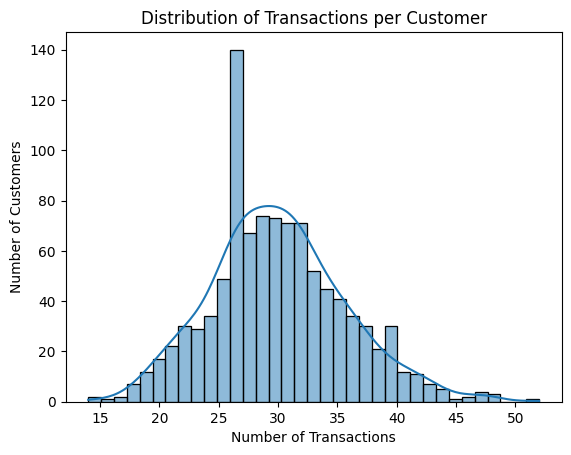

In [9]:
sns.histplot(df.groupby('CustomerID')['TransactionID'].count(), kde=True, bins=35, edgecolor='black')
plt.title('Distribution of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

In [10]:
df.groupby('CustomerID')['TransactionID'].count()

CustomerID
C1       34
C10      31
C100     30
C1000    31
C101     42
         ..
C995     25
C996     15
C997     26
C998     28
C999     43
Name: TransactionID, Length: 1000, dtype: int64

In [11]:
order_counts = df.groupby('CustomerID')['TransactionID'].count()
order_counts.value_counts().sort_index()

TransactionID
14     1
15     1
16     1
17     2
18     7
19    12
20    17
21    22
22    30
23    29
24    34
25    49
26    61
27    79
28    67
29    74
30    73
31    71
32    71
33    52
34    45
35    41
36    34
37    30
38    21
39    16
40    14
41    12
42    11
43     7
44     5
45     1
46     2
47     4
48     3
52     1
Name: count, dtype: int64

In [12]:
print(df['Timestamp'].min())
print(df['Timestamp'].max())

2025-01-01
2025-04-30


In [13]:
df['Products'].apply(lambda x: len(x.split(','))).describe()

count    30000.000000
mean         6.583633
std          2.332464
min          3.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         11.000000
Name: Products, dtype: float64

In [14]:
duplicated = df.Products[df['Products'].duplicated()]

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(duplicated)

856                         Fish, Juice, Lentil
3496                   Milk, Juice, Dish Sponge
3888                    Lentil, Pizza, Cucumber
5330                     Pizza, Fish, Chickpeas
6743                  Sausage, Honey, Ice Cream
6804                         Cereal, Honey, Egg
7663                        Lentil, Fish, Honey
7965               Pizza, Cucumber, Honey, Soda
8628                  Chickpeas, Bread, Cracker
9441                 Beans, Soap, Water, Lentil
9515           Soda, Dish Sponge, Potato, Water
10225         Pizza, Flatbread with Meat, Onion
10354        Tomato, Pizza, Flatbread with Meat
10432        Chickpeas, Dish Sponge, Strawberry
10831                     Tomato, Cereal, Pizza
10866                       Onion, Cracker, Egg
10884                       Onion, Cola, Tomato
11002                    Sausage, Chips, Yogurt
11043                      Pizza, Butter, Chips
11202                    Fish, Chicken, Sausage
11559                  Soda, Minced Meat

In [16]:
df['Product_list'] = df['Products'].apply(lambda x: [p.strip() for p in x.split(',')])

In [17]:
df.head()

,TransactionID,CustomerID,Products,Timestamp,Product_list
0,1,C546,"Dish Sponge, Flatbread with Meat, Chips, Orang...",2025-02-18,"[Dish Sponge, Flatbread with Meat, Chips, Oran..."
1,2,C385,"Onion, Juice, Flatbread with Meat, Chicken",2025-04-26,"[Onion, Juice, Flatbread with Meat, Chicken]"
2,3,C292,"Egg, Flatbread with Meat, Banana, Pizza",2025-04-25,"[Egg, Flatbread with Meat, Banana, Pizza]"
3,4,C863,"Ice Cream, Soda, Orange, Potato, Cereal, Choco...",2025-01-14,"[Ice Cream, Soda, Orange, Potato, Cereal, Choc..."
4,5,C171,"Ice Cream, Soap, Shampoo, Chicken, Banana, Bea...",2025-04-20,"[Ice Cream, Soap, Shampoo, Chicken, Banana, Be..."


In [18]:
unique_products = set(chain.from_iterable(df['Product_list']))

In [19]:
len(unique_products)

40

In [20]:
unique_products

{'Apple',
 'Banana',
 'Beans',
 'Bread',
 'Butter',
 'Cereal',
 'Cheese',
 'Chicken',
 'Chickpeas',
 'Chips',
 'Chocolate',
 'Cola',
 'Cookie',
 'Cracker',
 'Cucumber',
 'Detergent',
 'Dish Sponge',
 'Dumpling',
 'Egg',
 'Fish',
 'Flatbread with Meat',
 'Honey',
 'Ice Cream',
 'Juice',
 'Lentil',
 'Milk',
 'Minced Meat',
 'Onion',
 'Orange',
 'Pizza',
 'Potato',
 'Rice',
 'Sausage',
 'Shampoo',
 'Soap',
 'Soda',
 'Strawberry',
 'Tomato',
 'Water',
 'Yogurt'}

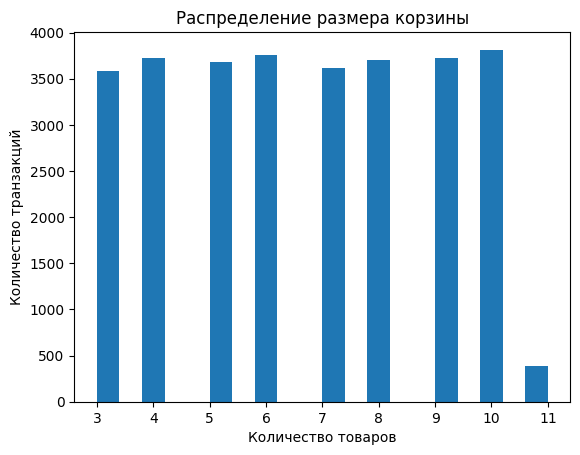

In [21]:
plt.hist(df['Products'].apply(lambda x: len(x.split(','))), bins=20)
plt.title('Распределение размера корзины')
plt.xlabel('Количество товаров')
plt.ylabel('Количество транзакций')
plt.show()

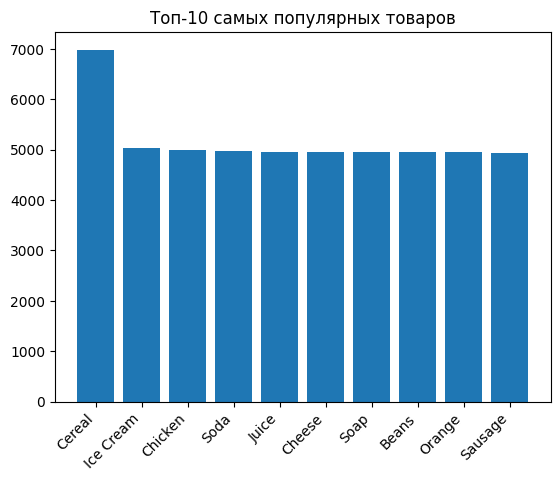

In [22]:
from collections import Counter

all_products = list(chain.from_iterable(df['Product_list']))
product_counts = Counter(all_products)
top_products = product_counts.most_common(10)

plt.bar([p[0] for p in top_products], [p[1] for p in top_products])
plt.xticks(rotation=45, ha='right')
plt.title('Топ-10 самых популярных товаров')
plt.show()

In [23]:
df.head()

,TransactionID,CustomerID,Products,Timestamp,Product_list
0,1,C546,"Dish Sponge, Flatbread with Meat, Chips, Orang...",2025-02-18,"[Dish Sponge, Flatbread with Meat, Chips, Oran..."
1,2,C385,"Onion, Juice, Flatbread with Meat, Chicken",2025-04-26,"[Onion, Juice, Flatbread with Meat, Chicken]"
2,3,C292,"Egg, Flatbread with Meat, Banana, Pizza",2025-04-25,"[Egg, Flatbread with Meat, Banana, Pizza]"
3,4,C863,"Ice Cream, Soda, Orange, Potato, Cereal, Choco...",2025-01-14,"[Ice Cream, Soda, Orange, Potato, Cereal, Choc..."
4,5,C171,"Ice Cream, Soap, Shampoo, Chicken, Banana, Bea...",2025-04-20,"[Ice Cream, Soap, Shampoo, Chicken, Banana, Be..."


# Dataset prep

In [24]:
transactions = df['Product_list'].tolist()

In [25]:
te = TransactionEncoder()

In [26]:
te_ary = te.fit(transactions).transform(transactions)

In [27]:
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

In [28]:
basket_df.head()

,Apple,Banana,Beans,Bread,Butter,Cereal,Cheese,Chicken,Chickpeas,Chips,...,Potato,Rice,Sausage,Shampoo,Soap,Soda,Strawberry,Tomato,Water,Yogurt
0,False,False,False,False,True,False,False,False,False,True,...,False,True,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,False,True,True,False,False,False,True,True,False,False,...,False,False,False,True,True,False,False,False,False,False


In [29]:
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Apple                30000 non-null  bool 
 1   Banana               30000 non-null  bool 
 2   Beans                30000 non-null  bool 
 3   Bread                30000 non-null  bool 
 4   Butter               30000 non-null  bool 
 5   Cereal               30000 non-null  bool 
 6   Cheese               30000 non-null  bool 
 7   Chicken              30000 non-null  bool 
 8   Chickpeas            30000 non-null  bool 
 9   Chips                30000 non-null  bool 
 10  Chocolate            30000 non-null  bool 
 11  Cola                 30000 non-null  bool 
 12  Cookie               30000 non-null  bool 
 13  Cracker              30000 non-null  bool 
 14  Cucumber             30000 non-null  bool 
 15  Detergent            30000 non-null  bool 
 16  Dish Sponge          3